#  Condensed Nearest Neighbor

Jakub Darul

Lab2

In [1]:
%matplotlib inline

import random
from typing import Callable
from typing import List, Tuple, Optional

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import sklearn.neighbors as nb

import cnn_sklearn
import img_utils
import knn_sklearn
import sklearn_utils
from point import Point


Wybrałem te same zbiory punktów ( obrazki ) co dla zadania metric learning. (Szum został dodany na nowo).

In [2]:
images = "small_density.bmp,small_face.bmp,small_galaxy.bmp,wave.bmp".split(",")
labels=["Horse","Face","Galaxy","Wave"]
images = img_utils.load_and_preprocess_all(images)

images_points=[]

for image,label in zip(images,labels):
        pts=knn_sklearn.add_noise(image.shape,img_utils.get_points(image),radius=0.4)
        images_points.append(pts)

Badane przypadki:

1. zwykły k-NN z k=1 i metryką Euklidesa; 
2. CNN z k=1 i metryką Euklidesa (losowo wybierający próbki w procedurze kondensacji); 
3. CNN z k=1 i metryką Euklidesa (wybierający próbki w oparciu o ich border ratio - ładnie wyjaśnione na wikipedii); 
4. zwykły k-NN z k=3 i metryką Euklidesa; 
5. CNN z k=3 i metryką Euklidesa 

Funkcje pomocnicze w prezentowaniu wyników:

In [3]:
def present_classifier(
        pts: List[Point],
        classifier_provider: Callable[
            [List[Point]], Tuple[nb.KNeighborsClassifier, Optional[float], Optional[List[Point]]]],
        title: str,
        h: float = 0.4):
    
    clf, _, new_pts = classifier_provider(pts)
    X, y = img_utils.get_X_y(pts if new_pts is None else new_pts)
    sklearn_utils.fit_and_plot(clf, X, y, title, h)

    avg, std_dev, cnn_avg, cnn_std = knn_sklearn.get_accuracy_sklearn_avg(classifier_provider, pts)
    print("Accuracy: {}% ± {}".format(avg * 100, std_dev * 100))
    if cnn_avg is not None:
        print("PointsAfterCnn/PointsBeforeCnn :{}% ±{}".format(cnn_avg * 100, cnn_std * 100))


def cnn_provider(k: int, dists: Optional[cnn_sklearn.ClosestDists]):
    def inner(p: List[Point]):
        new_p = cnn_sklearn.cnn(p[:k], p[k:], k=k, closest_distances=dists)
        cnn_ratio = len(new_p) / len(p)

        res = nb.KNeighborsClassifier(k, 'uniform', metric='euclidean')
        x, y = knn_sklearn.get_X_y(new_p)
        res.fit(x, y)
        return res, cnn_ratio, new_p
    return inner


def knn_provider(k: int):
    def inner(p: List[Point])-> Tuple[nb.KNeighborsClassifier, Optional[float], Optional[List[Point]]]:
        res = nb.KNeighborsClassifier(k, 'uniform', metric='euclidean')
        x, y = knn_sklearn.get_X_y(p)
        res.fit(x, y)
        return res, None, None
    return inner


def present(pts: List[Point]):
    sklearn_utils.plot_just_points(pts, "Base image")
    random.shuffle(pts)
    closest_dists = cnn_sklearn.ClosestDists(pts)

    #1
    present_classifier(pts, knn_provider(k=1), "k=1, euclidean metric")

    #2
    present_classifier(pts, cnn_provider(k=1, dists=None),
                       "cnn k=1, euclidean metric")

    #3
    present_classifier(pts, cnn_provider(k=1, dists=closest_dists),
                       "cnn border ratio, k=1, euclidean metric")

    #4
    present_classifier(pts, knn_provider(k=3), "k=3, euclidean metric")

    #5

    present_classifier(pts, cnn_provider(k=3, dists=None),
                       "cnn k=3, euclidean metric")


Zdecydowałem się prezentować wyniki grupując je po zbiorach punktów:

Horse


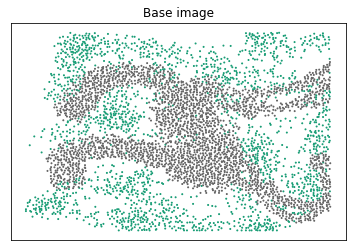

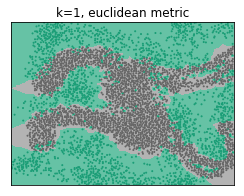

Accuracy: 91.25% ± 0.29


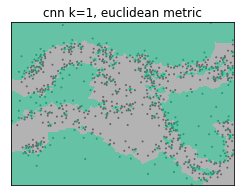

Accuracy: 89.55% ± 0.77
PointsAfterCnn/PointsBeforeCnn :19.27% ±0.67


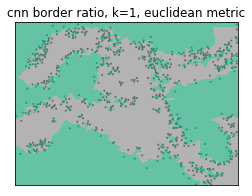

Accuracy: 89.77000000000001% ± 0.59
PointsAfterCnn/PointsBeforeCnn :17.07% ±0.44999999999999996


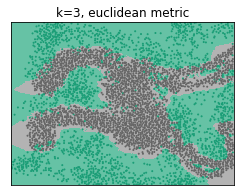

Accuracy: 92.58999999999999% ± 0.35000000000000003


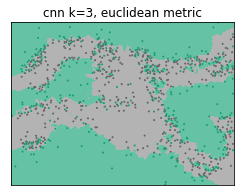

Accuracy: 91.39% ± 0.69
PointsAfterCnn/PointsBeforeCnn :19.35% ±0.67
Face


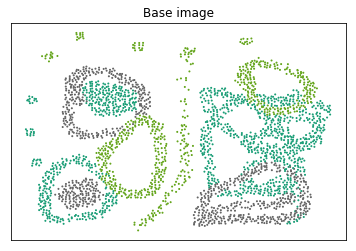

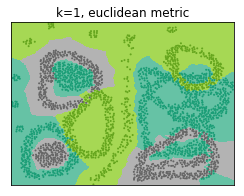

Accuracy: 95.5% ± 0.63


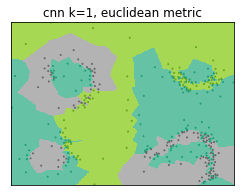

Accuracy: 94.52000000000001% ± 0.62
PointsAfterCnn/PointsBeforeCnn :13.209999999999999% ±0.5


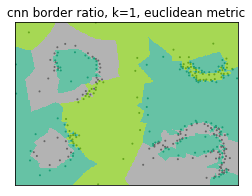

Accuracy: 93.97% ± 0.72
PointsAfterCnn/PointsBeforeCnn :12.13% ±0.52


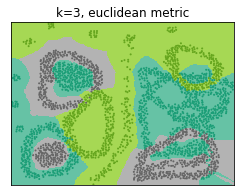

Accuracy: 95.94% ± 0.62


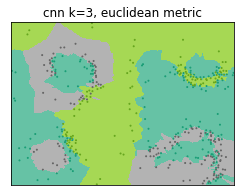

Accuracy: 94.69999999999999% ± 0.6
PointsAfterCnn/PointsBeforeCnn :15.920000000000002% ±0.58
Galaxy


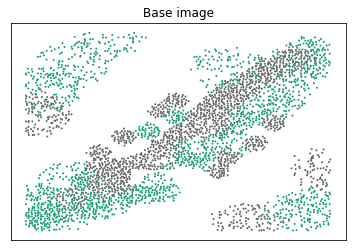

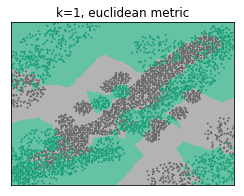

Accuracy: 87.58% ± 0.65


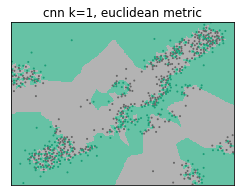

Accuracy: 86.3% ± 1.0999999999999999
PointsAfterCnn/PointsBeforeCnn :23.78% ±0.65


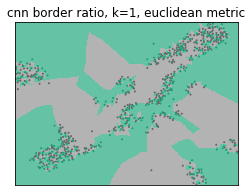

Accuracy: 85.2% ± 0.67
PointsAfterCnn/PointsBeforeCnn :21.7% ±0.86


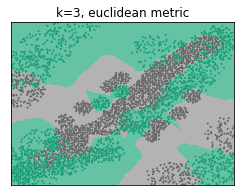

Accuracy: 88.4% ± 1.2


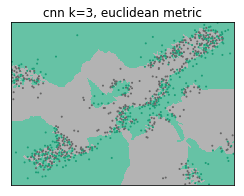

Accuracy: 87.03% ± 0.83
PointsAfterCnn/PointsBeforeCnn :25.779999999999998% ±0.5700000000000001
Wave


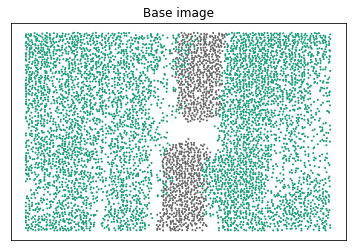

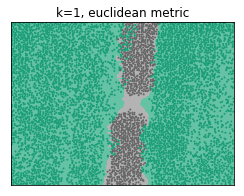

Accuracy: 97.69% ± 0.32


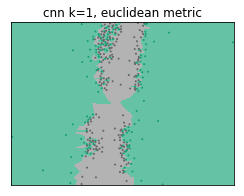

Accuracy: 97.24000000000001% ± 0.32
PointsAfterCnn/PointsBeforeCnn :5.47% ±0.22999999999999998


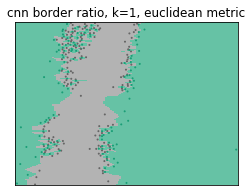

Accuracy: 97.11% ± 0.27
PointsAfterCnn/PointsBeforeCnn :4.73% ±0.13999999999999999


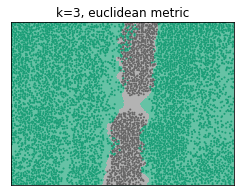

Accuracy: 97.6% ± 0.27


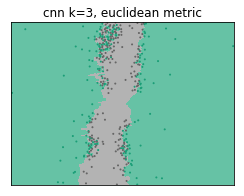

Accuracy: 97.3% ± 0.27
PointsAfterCnn/PointsBeforeCnn :6.11% ±0.31


In [4]:
for label, p in zip(labels, images_points):
    print(label)
    present(p)


Accuracy dla cnn jest prównywalne do accuracy bez cnn.

Dla sprawdzania accuracy dzieląc punkty po cnn otrzymywałem bardzo niskie wniki, gdyż zbiór wiedzy po cnn jest minimalny - zabranie części punktów w celu testowania znacznie obniża posiadaną wiedzę skąd bardzo niska dokładność.